# Bang Bang (My Baby Shot Me Downey)

Bennett & Jerry<br/>Section 1

# Question

### What temperature range of operation is needed from a bang-bang heater to result in a steady ambient temperature of 25 degrees celsius, given heat loss to the environment?

# Model

&nbsp; &nbsp; &nbsp; When deciding on our model, we went through several questions: heat loss in the AC, thermal retention of window glass, even what would happen were the sun to go out. After consulting with the NINJAs and reflecting on what topics we were capable of pursuing, we decided to combind our interest in thermodynamics with the newly discovered topics of bang-bang heaters. Bang-bang heaters are heaters that are either on, and pumping out as much heat as they can muster, or off entirely. The question we decided to pursue was at what temperature would the heater have to turn itself on, and later off, in order to maintain an efficient and stable temperatue, given heat loss from the room it is heating to the environment. </br>

&nbsp; &nbsp; &nbsp; In our model, we have simplified the room to a 10 m by 10 m by 5 m box, with all walls but one being perfectly thermally insulated. The final wall, 10 m by 10 m, is constructed out of single pane glass, with a thermal coefficient found via research into building specs of commercial buildings. We assumed that the room is a single thermal object, losing its heat to an unchanging environment at a rate of U*A*deltaT, with U being the thermal coefficient of the surface in contact with the environment, A being the area of said surface, and delta T being the difference between the interior and exterior temperatures. The room was assumed to have constant volume, as dictated by the usage of the equation, which requires this parameter. This would also limit potential errors in our calculations and be relatively accurate under ideal conditions which helps our model significantly. The U value for the glass was assumed to have been 1.05, as found on an encyclopedia of the thermal conductivity of building materials, despite U-values varying for different types of glass.</br>

&nbsp; &nbsp; &nbsp; Our data was verified by the use of a secondary model, Build It Solar's Home Heat Loss Calculator. After inputting the various dimensions and thermal conductivity of the room, it delivered a series of values of rates of heat loss and returned the temperature of the room at various points in time. Using Excel to find the line of best fit, we were able to turn the given data points into a polynomial equation, which we graphed using discrete tiemsteps. This became our baseline for the heat loss of the room, and we utilized it in validating the base of our model, the rate of thermal energy loss. The later introduction of the thermal energy input by the bang-bang heater was also in part validated off of this principle, as when searching for a "break-even" input rate, it additionally relied on the rate of thermal energy loss to be determined.</br>

## Importing and Configuration

In [53]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Creating the System
**temp_out:** Exterior Temperature, input in Fahrenheit </br> 

**t_oc:** Exterior Temperatur, converted to Celsius </br>
* Rate of Thermal Energy Loss equation given in BTU, and takes C in its calculation

**area:** Surface Area of plane exposed to the environment </br>

**heat_coeff:** Thermal Conductivity of the material of the plane </br>

**rate_in:** The rate of input of thermal energy by the heater </br>

**difff:** Variable used to hold shift in range of heater activity </br>

In [54]:
def make_system(temp_out, area, heat_coeff, rate_in, difff): #requested inputs
    
    init = State(temp = 25)
    
    #converted to celcius per BTU
    t_oc = (temp_out-32)*5/9
        
    A = area 
    U = heat_coeff
    rate_in = rate_in
    difff = difff
    
    t0 = 0
    t_end = 10000
    

    
    return System (init = init, t_oc = t_oc, A = A, U = U, t0 = t0,
                   t_end = t_end, rate_in = rate_in, difff = difff) #initialization of system
    
#currently set up so that there is a single heat_coeff value.

#potentially a need to initialize a system to test each heat_coeff value
#lack of heat_coeff values, need for a nonlinear array of values

## Slope Function


In [7]:
def slope_func(state, t, system):

    Temp = state
        
    #calculate rate of heat loss
    dHdtJ = system.U * (Temp - system.t_oc) * system.A
    
    # converted from joules to degrees celsius
    dHdt = -dHdtJ / 430800
    
    # return the rate of heat loss
    return dHdt
    

In [8]:
system = make_system(40, 100, 1, 0, 0)

,values
init,temp 25 dtype: int64
t_oc,4.44444
A,100
U,1
t0,0
t_end,10000
rate_in,0
dt,5
difff,0


In [9]:
#test slope_func
slope_func(system.init, 0, system)

temp   -0.004771
dtype: float64

## Run Ode Solver, Validation

In [10]:
results, details = run_ode_solver(system,slope_func)
details

,values
sol,None
t_events,[]
nfev,44
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [11]:
#calculate polynomial derived from given heat loss model
#parameters of room (10m by 10 m by 5 m) and thermal coefficient of glass (1.05) input
#listed results input and trendline calulated in Excel

#continuous equation handled through use of linrange
trendtime = linrange(0, 10000, 1)

#given model rewritten as a graphable equation
    #given model was not transparent, and therefore could not be replicated except through interpretation of its data
trendline = 2e-7*(trendtime)**2 - 0.0038*(trendtime) + 24.873

array([24.873    , 24.8692002, 24.8654008, ...,  6.8724018,  6.8726008,
        6.8728002])

In [12]:
def plot_results(results, trendline, title):
    
    #plot trendline and modeled temp
    #comparison validates heat loss equation and modeling
    plot(trendline, '--', label='Trendline')
    plot(results['temp'], '.-', label='Modeled Temperature')
    decorate(xlabel='Seconds', 
             ylabel='Temperature (degrees C)',
             title=title)

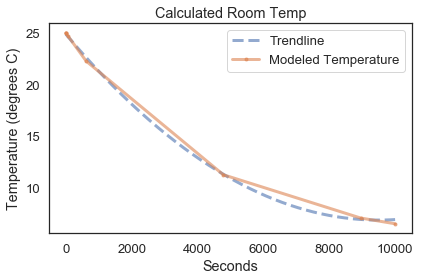

In [13]:
plot_results(results, trendline, 'Calculated Room Temp')

## Updating Slope Func, Validation


In [55]:
def slope_func2(state, t, system):

    Temp = state
        
    #calculate rate of heat loss
    dHdtJ = system.U * (Temp - system.t_oc) * system.A
    
    # converted from joules to degrees celsius
    dHdt = -dHdtJ / 430800
    
    # introduce heat input equation- current input is arbitrary, to be swept later 
    dIdt = 1000 / 430800
    
    #combination rate: input minus output
    dCdt = dIdt + dHdt
    
    #return heat loss rate if heater is off (when in ideal temp range)
    if (30 < int(Temp) < 21):
        
        return dHdt
    
    #return loss and input if in non ideal temp range (heater on)
    else:
        return dCdt    

In [56]:
results2, details = run_ode_solver(system,slope_func2)
details

,values
sol,None
t_events,[]
nfev,38
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


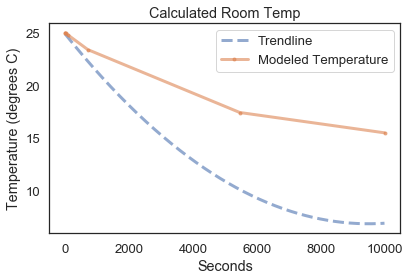

In [16]:
plot_results(results2, trendline, 'Calculated Room Temp')

In [17]:
#heat loss shown to be impacted, room ending at higher temperature
    #heat input equation functional
#introduce max_step
results3, details = run_ode_solver(system,slope_func2, max_step=5)
details

,values
sol,None
t_events,[]
nfev,12008
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


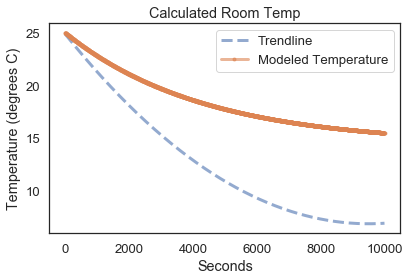

In [18]:
#note the rippling in the temperature readings
#bang bang heater causing small changes in temperature when the threshold is reached
#it is this phenomenon that we will focus on
import matplotlib.pyplot as plt
plot_results(results3, trendline, 'Calculated Room Temp')

## Sweeping Heater Input Rate

In [31]:
#sweep possible heat input values
rate_array = linspace(1000, 3000, 5)       
    
"""
for rate_in in rate_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))
"""
def slope_func4(state, t, system):

    Temp = state
    
    #calculate rate of heat loss
    dHdtJ = system.U * (Temp - system.t_oc) * system.A
    
    # converted from joules to degrees celsius
    dHdt = -dHdtJ / 430800
    
    # introduce heat input equation- current input is arbitrary, to be swept later 
    dIdt = system.rate_in / 430800
    
    #combination rate: input minus output
    dCdt = dIdt + dHdt
    
    #return heat loss rate if heater is off (when in ideal temp range)
    if (30 < int(Temp) < 21):
        return dHdt
    
    #return loss and input if in non ideal temp range (heater on)
    else:
        return dCdt

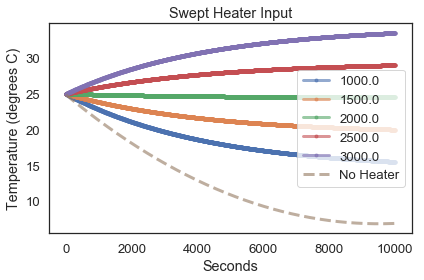

In [37]:
#Note: Values of heater input is in J*430800/s
for rate_in in rate_array:
    system = make_system(40, 100, 1, rate_in, 0)
    results, details = run_ode_solver(system, slope_func4, max_step=5)
    plot(results['temp'], '.-', label=rate_in)

plot(trendline, '--', label='No Heater')
decorate(xlabel='Seconds', 
         ylabel='Temperature (degrees C)',
         title='Swept Heater Input')

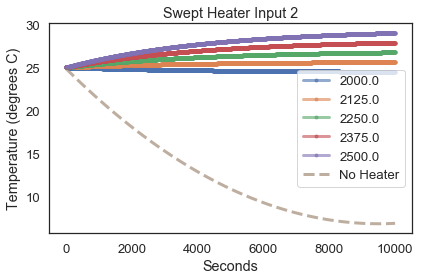

In [38]:
#second sweep, centering in on the semi-horizontal rate around 2000
rate_array2 = linspace(2000, 2500, 5)  
for rate_in in rate_array2:
    system = make_system(40, 100, 1, rate_in, 0)
    results, details = run_ode_solver(system, slope_func4, max_step=5)
    plot(results['temp'], '.-', label=rate_in)

plot(trendline, '--', label='No Heater')
decorate(xlabel='Seconds', 
         ylabel='Temperature (degrees C)',
         title='Swept Heater Input 2')

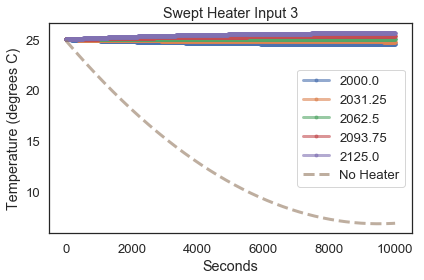

In [39]:
#final sweep, centering in on the rate between 2000 and 2125
rate_array3 = linspace(2000, 2125, 5) 

for rate_in in rate_array3:
    system = make_system(40, 100, 1, rate_in, 0)
    results, details = run_ode_solver(system, slope_func4, max_step=5)
    plot(results['temp'], '.-', label=rate_in)

plot(trendline, '--', label='No Heater')
decorate(xlabel='Seconds', 
         ylabel='Temperature (degrees C)',
         title='Swept Heater Input 3')

## Sweeping Heater Temperature Range

In [26]:
#to answer question: sweep possible range values
diff_array = linspace(0, 24, 5)  

def slope_func5(state, t, system):

    Temp = state
    
    #calculate rate of heat loss
    dHdtJ = system.U * (Temp - system.t_oc) * system.A
    
    # converted from joules to degrees celsius
    dHdt = -dHdtJ / 430800
    
    # utilize optimal heter input as found in sweep- 0.00464 J/s 
    dIdt = 2062.5 / 430800
    
    #combination rate: input minus output
    dCdt = dIdt + dHdt
    
    #each increasing interval of system.difff will decrease the range in which the heater is off
    if ((50-system.difff) > int(Temp) > (0+system.difff)):
        return dHdt
    
    #return loss and input if in non ideal temp range (heater on)
    else:
        return dCdt

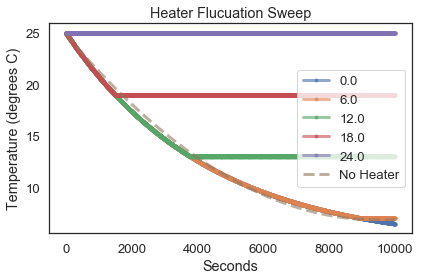

In [28]:
for difff in diff_array:
    system = make_system(40, 100, 1, 2111, difff)
    results, details = run_ode_solver(system, slope_func5, max_step=5)
    plot(results['temp'], '.-', label = difff)

plot(trendline, '--', label='No Heater')
decorate(xlabel='Seconds', 
         ylabel='Temperature (degrees C)',
         title='Heater Flucuation Sweep')

# Results

**Question**: What temperature range of operation is needed from a bang-bang heater to result in a steady ambient temperature of 25 degrees celsius, given heat loss to the environment? </br>

**Our Answer**: Through research and our simulation, we found that the heater would need to operate at a range of 24 degrees to 26 degrees to maintain a constant output of 25. While simplistic in hindsight, the dropoffs of the other temperature ranges represent inefficient temperature outputs, demonstrating the definitive need for a one degree leeway. 

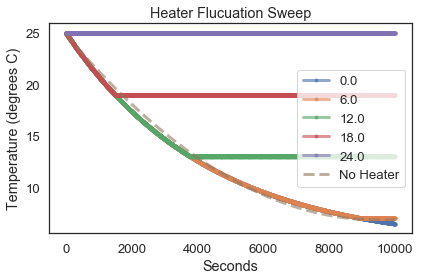

In [60]:
for difff in diff_array:
    system = make_system(40, 100, 1, 2111, difff)
    results, details = run_ode_solver(system, slope_func5, max_step=5)
    plot(results['temp'], '.-', label = difff)

plot(trendline, '--', label='No Heater')
decorate(xlabel='Seconds', 
         ylabel='Temperature (degrees C)',
         title='Heater Flucuation Sweep')

 The graph shows how the temperature of the room changes with varying energy inputs of the heater. In comparison to the graphs with a greater range, the energy output of the heater has less variation from 25 degrees with the 2 degree (labeled 24, for the difff value) line. Each consecutive value of greater divide shows a drop in the temperature capable of being maintained at that heat output. The high and low for the 2 degree range is relatively close to 25 and shows that that is the optimal range for the bang bang heater’s function. A smaller range can lead to more effective temperature control. 

## Main Limitation
&nbsp; &nbsp; &nbsp; The main limitation of the model would be the fogginess of its self assessment. It may include an accurate assessment of the rate of thermal energy exiting the room due to the potentially inaccurate value for the heat transfer coefficient, bu thte method by which this was verified was a black box. We were not able to find the equations by which the Home Heat Loss Calculator developed its values, and had to ourselves recreate a modeling equation to fit into our notebook. The fact that a smaller range of bang bang heater operation would require the heater to be on more frequently and consume more energy would make the optimal temperature regulation scenario less preferable as well, given the need for further information into cost and sustainability information, which would drive our model more towards a data question. 

## Iteration
&nbsp; &nbsp; &nbsp; Our iterative process is shown above, as each major change in the code is documented in sequence. Beginning first with a simple model of heat loss, and its subsequent validation, our model grew to include heat output, then varying heat output, than varying operation of a swept heat output. Our major data values were determined in-model, based off of verified assumptions and vaidated date, using sweeps of the heat input rate and fluctuation range. </br>

&nbsp; &nbsp; &nbsp; Research was conducted in bulk at the beginning of the project, but more efficient equations were continually discovered. With large portions of unit conversion work being done by hand, the mathematical intricacies of the model were continually shifting. One major step was the conversion of the joule per second energy rates into degree celsius per second area, in opposition to the previously used method of shifting all temperature measurements into joules. This made working with units much simpler, and greatly reduced the effort needed to manage the frequently changing units of our model.

# Abstract

&nbsp; &nbsp; &nbsp; We created this model to find what temperature range of operation is needed from a bang-bang heater to maintain 25 degrees celsius in a given area, given heat loss to the environment. With the found optimal temperature of 2062.5/430800 joules/sec output, we determined that a 2 degree range was optimal for maintaining 25 degrees.


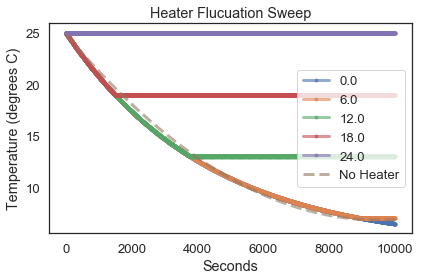

&nbsp; &nbsp; &nbsp; This graph shows the overall results of our simulation over 2.78 hours, and the varying levels of constant temperature that result from different ranges. The labels, read as "Range of Deactivation Between 50-x and x Degrees C", note the various tested values for range. As the graph shows, 24, or a range of deactivation between 26 and 24 degrees C, presents the most direct result of 25 degrees.
</br>

&nbsp; &nbsp; &nbsp; The ideal function of a bang-bang heater, though a mechanically simple device, is helpful in its usage in efficiently maintaining the heat of a building. Were one to compare rates of fluction against cost, given their method of heating and budjet/need, this model could provide the more efficient constraints by which to construct their system.